In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs, verbose=False):
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))

            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))

            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):

            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            fake_state = K.zeros_like(inputs)
            fake_state = K.sum(fake_state, axis=[1, 2])
            fake_state = K.expand_dims(fake_state)
            fake_state = K.tile(fake_state, [1, hidden_size])
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])

        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [ ]:
import numpy as np
import pandas as pd 
import re
from keras.preprocessing.text import Tokenizer 
from nltk import download
download('stopwords')
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
reviews = pd.read_json ("/content/drive/My Drive/reviews/Cell_Phones_and_Accessories_og.json")

In [ ]:
reviews.head()

,Rating,Rev_verify,Review_Date,IC,Prod_meta,Reviewer_Name,Review,Rev_summ,Review_timestamp,Useful,Prod_img
0,5,True,"09 1, 2015",B009XD5TPQ,None,Sunny Zoeller,Bought it for my husband. He's very happy with it,He's very happy with,1441065600,None,None
1,5,True,"01 9, 2016",B016MF3P3K,None,Denise Lesley,Great screen protector. Doesn't even seem as ...,Five Stars,1452297600,None,None
2,5,True,"04 21, 2013",B008DC8N5G,None,Emir,Saved me lots of money! it's not gorilla glass...,As long as you know how to put it on!,1366502400,None,None
3,3,True,"02 27, 2013",B0089CH3TM,{'Color:': ' Green'},Alyse,"The material and fit is very nice, but the col...",Good case overall,1361923200,3,None
4,4,True,"12 19, 2013",B00AKZWGAC,None,TechGuy,This last me about 3 days till i have to charg...,Awesome Battery,1387411200,None,None


In [ ]:
reviews.shape

(760450, 11)

In [ ]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 760450 entries, 0 to 760449
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Rating            760450 non-null  int64 
 1   Rev_verify        760450 non-null  bool  
 2   Review_Date       760450 non-null  object
 3   IC                760450 non-null  object
 4   Prod_meta         407826 non-null  object
 5   Reviewer_Name     760359 non-null  object
 6   Review            759920 non-null  object
 7   Rev_summ          760095 non-null  object
 8   Review_timestamp  760450 non-null  int64 
 9   Useful            62200 non-null   object
 10  Prod_img          18194 non-null   object
dtypes: bool(1), int64(2), object(8)
memory usage: 64.5+ MB


In [ ]:
reviews.drop(columns=['Rev_verify', 'Review_Date', 'Prod_meta', 'Reviewer_Name', 'Review_timestamp', 'Useful', 'Prod_img', 'IC', 'Rating'],axis=0,inplace=True)

In [ ]:
reviews.rename(columns = {'Review':'review', 'Rev_summ':'summary'}, inplace=True)

In [ ]:
reviews.head()

,review,summary
0,Bought it for my husband. He's very happy with it,He's very happy with
1,Great screen protector. Doesn't even seem as ...,Five Stars
2,Saved me lots of money! it's not gorilla glass...,As long as you know how to put it on!
3,"The material and fit is very nice, but the col...",Good case overall
4,This last me about 3 days till i have to charg...,Awesome Battery


In [ ]:
reviews.isnull().sum()

review     530
summary    355
dtype: int64

In [ ]:
reviews = reviews.dropna()

In [ ]:
reviews.isnull().sum()

review     0
summary    0
dtype: int64

In [ ]:
reviews.shape

(759602, 2)

In [ ]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 759602 entries, 0 to 760449
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   review   759602 non-null  object
 1   summary  759602 non-null  object
dtypes: object(2)
memory usage: 17.4+ MB


In [ ]:
# see some reviews
for i in range(5):
    print("Review:",i+1)
    print(f"Summary : {reviews.summary[i]}")
    print(f"Review  : {reviews.review[i]}")
    print()

Review: 1
Summary : He's very happy with
Review  : Bought it for my husband. He's very happy with it

Review: 2
Summary : Five Stars
Review  : Great screen protector.  Doesn't even seem as though it's on there

Review: 3
Summary : As long as you know how to put it on!
Review  : Saved me lots of money! it's not gorilla glass, so be careful as it will be subject to easier scratching. it also doesn't have sticky stuff on the glass like the original. If you press hard on the glass, the digitizer will go crazy. Just shut the screen on and off, and you'll be fine.

Review: 4
Summary : Good case overall
Review  : The material and fit is very nice, but the color is more of a neon green than I expected or would have liked.

Review: 5
Summary : Awesome Battery
Review  : This last me about 3 days till i have to charge it. It does take FOREVER to charge so make sure you plug it in early at night so it will be fully charged in the morning. Sometimes I will get home late (1AM) and when i wake up (10

# Lets cleaned datasets

In [ ]:
contractions =          {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have", "i've": "i have"}

In [ ]:
def clean_text(text, remove_stopwords = True):
    
    text = text.lower()
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
        
    text = re.sub(r'https?:\/\/*[\r\n]*', '', text, flags=re.MULTILINE)
    text = ' '.join([contractions[t] if t in contractions else t for t in text.split(" ")])    
    text = re.sub(r'[_"\-;%()|+&=*%,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r"'s\b","", text)
    text = re.sub(r'&amp;', '', text) 
    
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text    

In [ ]:
cleaned_summary = []
for summary in reviews['summary']:
    cleaned_summary.append(clean_text(summary, remove_stopwords=True))
print("Summary has been cleaned and saved as cleaned_summary.")

Summary has been cleaned and saved as cleaned_summary.


In [ ]:
cleaned_reviews = []
for review in reviews['review']:
    cleaned_reviews.append(clean_text(review))
print("Reviews has been cleaned and saved as cleaned_reviews.")

Reviews has been cleaned and saved as cleaned_reviews.


In [ ]:
# see clean reviews
for i in range(5):
    print("Review:",i+1)
    print(f"Summary : {cleaned_summary[i]}")
    print(f"Review  : {cleaned_reviews[i]}")
    print()

Review: 1
Summary : happy
Review  : bought husband. happy

Review: 2
Summary : five stars
Review  : great screen protector. even seem though

Review: 3
Summary : long know put
Review  : saved lots money gorilla glass careful subject easier scratching. also sticky stuff glass like original. press hard glass digitizer go crazy. shut screen fine.

Review: 4
Summary : good case overall
Review  : material fit nice color neon green expected would liked.

Review: 5
Summary : awesome battery
Review  : last 3 days till charge it. take forever charge make sure plug early night fully charged morning. sometimes get home late 1am wake 10am 9 hours still charging 70 80 . take another 2 fully charged. go somewhere wake fully charged. anyways great battery time fully charge it.



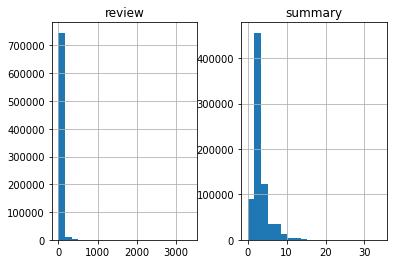

In [ ]:
# distribution of sequences
import matplotlib.pyplot as plt

reviews_word_count = []
summary_word_count = []

for i in cleaned_reviews:
    reviews_word_count.append(len(i.split()))
for i in cleaned_summary:
    summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'review': reviews_word_count, 'summary': summary_word_count})
length_df.hist(bins=20)
plt.show()

In [ ]:
count = 0
for i in cleaned_reviews:
    if(len(i.split())<=200):
        count += 1
print(count/len(cleaned_reviews))

0.987565856856617


In [ ]:
df=pd.DataFrame({'review':cleaned_reviews,'summary':cleaned_summary})
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['review']),np.array(df['summary']),test_size=0.3,random_state=0,shuffle=True)

In [ ]:
df.head()

,review,summary
0,bought husband. happy,sostok happy eostok
1,great screen protector. even seem though,sostok five stars eostok
2,saved lots money gorilla glass careful subject...,sostok long know put eostok
3,material fit nice color neon green expected wo...,sostok good case overall eostok
4,last 3 days till charge it. take forever charg...,sostok awesome battery eostok


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759602 entries, 0 to 759601
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   review   759602 non-null  object
 1   summary  759602 non-null  object
dtypes: object(2)
memory usage: 11.6+ MB


In [ ]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

In [ ]:
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

thresh=4
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 68.34651779363266
Total Coverage of rare words: 0.6091794320941528


In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

In [ ]:
#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

In [ ]:
#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq, maxlen=2, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=2, padding='post')

In [ ]:
#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [ ]:
print(x_voc)

29371


In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

thresh=6
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=3, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=3, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

y_tokenizer.word_counts['sostok'],len(y_tr)   

% of rare words in vocabulary: 74.82377033040602
Total Coverage of rare words: 1.170843233268607


(531721, 531721)

In [ ]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [ ]:
max_text_len = 200
from keras import backend as K 
K.clear_session()

latent_dim = 400
embedding_dim=110

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 2, 110)       3230810     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 2, 200), (No 248800      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=3,callbacks=[es],batch_size=500, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/3
1057/1057 [==============================] - 918s 869ms/step - loss: 1.9499 - val_loss: 1.8772
Epoch 2/3
1057/1057 [==============================] - 921s 872ms/step - loss: 1.8536 - val_loss: 1.8221
Epoch 3/3
1057/1057 [==============================] - 889s 841ms/step - loss: 1.8055 - val_loss: 1.7860


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Save Keras Model or weights on google drive

# create on Colab directory
model.save('review_summary.h5')    
model_file = drive.CreateFile({'title' : 'review_summary.h5'})
model_file.SetContentFile('review_summary.h5')
model_file.Upload()

# download to google drive
drive.CreateFile({'id': model_file.get('id')})

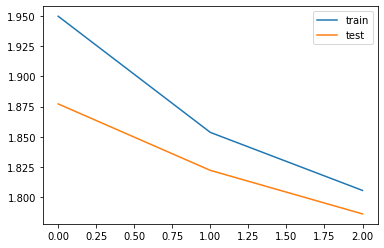

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
max_summary_len = 20
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(0,10):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: great product 
Original summary: great product 
Predicted summary:  love


Review: great product 
Original summary: five stars 
Predicted summary:  love


Review: thank you 
Original summary: carry around 
Predicted summary:  love


Review: omoton worked 
Original summary: bottom edge 
Predicted summary:  ok


Review: awesome love 
Original summary: awesome 
Predicted summary:  love


Review: well s6 
Original summary: four stars 
Predicted summary:  love


Review: world applications 
Original summary: use phone 
Predicted summary:  love


Review: given gift 
Original summary: battery power 
Predicted summary:  love


Review: be shame 
Original summary: battery last 
Predicted summary:  ok


Review: free happy 
Original summary: good 
Predicted summary:  love




In [ ]:
x_tr[i]

array([161, 120], dtype=int32)